In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

Reference: "Asymptotic formulae for likelihood-based tests of new physics" https://arxiv.org/abs/1007.1727

### Making a toy dataset

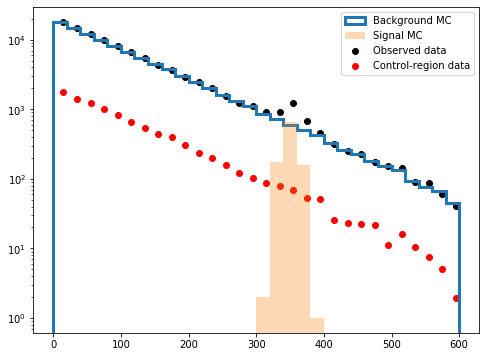

In [26]:
# Assuming this is Monte Carlo
plt.figure(figsize=(8,6))
background = np.random.exponential(100, round(1e5))
signal = np.random.normal(350,10, round(1e3))
bkg_count, _, _ = plt.hist(background, bins=30, range=(0, 600), histtype='step', linewidth=3, label='Background MC')
sig_count, _, _ = plt.hist(signal, bins=30, range=(0,600), histtype='stepfilled', alpha=0.3, label='Signal MC')

bin_center = np.arange(15,600,600/30)

# Assuming this is data
background_with_noise = np.random.normal(0, np.sqrt(bkg_count)) + bkg_count
signal_with_noise = np.random.normal(0, np.sqrt(sig_count)) + sig_count
obs_data = background_with_noise + signal_with_noise
plt.scatter(bin_center, obs_data, color='black', label='Observed data')

# Assuming the control region is 10% data without signal presence
control_region = 0.1 * background_with_noise + np.random.normal(0, np.sqrt(0.05*background_with_noise)) # with some additional noise
plt.scatter(bin_center, control_region, color='red', label='Control-region data')

plt.yscale('log')
plt.legend(loc='best')
plt.show()


### Test statistics $q_0$ for discovery of a positive signal



To discover new signal, we need to reject $\mu$ = 0 hypothesis. We have

$q_0 = 
-2\ln \lambda(0)$ for $\hat{\mu} \geq 0$ and zero for $\hat{\mu} < 0$, 

where $\lambda(0)$ is the profile likelihood ratio for $\mu$ = 0: 

$\lambda(\mu) = \frac{L(\mu,\hat{\hat{\theta}})}{L(\hat{\mu}, \hat{\theta})}$

In this case the $p$-value is computed as

$p_0 = \int_{q_{0,\textrm{obs}}}^{\infty} f(q_0 | 0) dq_0$

In a counting experiment, where one observes a number of events $n$, assumed to follow a Poisson distribution with an expectation value $E[n] = \mu s + b$, where $b$ is a nuissance parameter constrained by a control measurement, with expectation value $E[m] = \tau b$, where $b$ is the counting from the control region and $\tau$ is the transfer factor to the signal region. Thus the data consist of two measured values: $n$ from signal region and $m$ from control region. The parameter of interest is $\mu$ and one nuissance parameter is $b$. The likelihood function for $\mu$ and $b$ is the product of two Poisson terms:

$ L(\mu, b) = \frac{(\mu s + b)^n}{n!}e^{-(\mu s + b)} \frac{(\tau b)^m}{m!} e^{-\tau b}
$

In our case, since we measure $b$ from 10% of the signal region, we take $\tau$ = 0.1 (or 1/9... depending on how observed data is obtained)

Maximum likelihood estimator returns:

$\hat{\mu} = \frac{n - m/\tau}{s} $

$\hat{b} = \frac{m}{\tau} $

$\hat{\hat{b}} = \frac{n+m-(1+\tau)\mu s}{2(1+\tau)} + \left[ \frac{(n+m - (1+\tau) \mu s)^2 + 4(1+\tau) m \mu s}{4(1+\tau)^2} \right]^{1/2}$


Now the test statistics becomes
- If $\hat{\mu} = \frac{n-m}{s} \geq 0$:  $q_0 = -2 \ln \lambda(0) = \frac{L(0, \hat{\hat{\theta}})}{L(\hat{\mu}, \hat{\theta})}$
- If $\hat{\mu} = \frac{n-m}{s} < 0$:  $q_0 = 0$

Let's start first with the counting experiment (because doing the fit for shape analysis takes more effort and often fails...)

In [ ]:
# Defining necessary variables

def get_nll(mu, b, s, tau, N, M):
    """
    mu, b: array of bins. b is the expected background
    N: observed data
    M: observed background
    tau: scale factor for background
    s = 0 for null hypothesis, 1 for alternative hypothesis
    
    Return: -ln(L(N, M | mu,b,s))
    """
    average_signal = mu * s + b
    probs = sp.stats.poisson.pmf(average_signal.astype(np.int), N) * sp.stats.poisson.pmf(tau*b, M)
    probs = np.where(probs < 1e-10, np.full_like(probs, 1e-10), probs)
    NLL = np.sum(-np.log(probs), axis=-1)
    return NLL

def get_mu_hat(N, M, tau, s):
    return (N-M/tau)/s

def get_b_hat(M, tau):
    return M/tau

def get_b_doublehat(mu, b, s, N, M):
    return (N+M-(1+tau)*mu*s)/2(1+tau) + np.sqrt(((N+M-(1+tau)*M*s)**2 + 4(1+tau)*M*mu*s)/(4(1+tau)**2))

def Asimov_dataset(obs_data, control_region, bkg_count, sig_count, N_asymov=1e3):
    obs_asymov = np.random.poisson(obs_data, (N_asymov, obs_data.shape[0])) 
    ctrl_asymov = np.random.poisson(control_region, (N_asymov, control_region.shape[0]))
    tau = 0.1
    mu_hat = get_mu_hat(N=obs_asymov, M=ctrl_asymov, tau=tau, s=sig_count)
    b_hat = get_b_hat(M=ctrl_asymov, tau=tau)
    b_doublehat = get_b_doublehat(mu=0, b=bkg_count, s=sig_count, N=obs_asymov, M=ctrl_asymov)
    denominator = get_nll(mu=mu_hat, b=b_hat, s=sig_count, tau=tau, N=obs_asymov, M=ctrl_asymov)
    numerator = get_nll(mu=0, b=b_doublehat, s=sig_count, tau=tau, N=obs_asymov, M=ctrl_asymov)
    q_0 = np.where(mu_hat>0, numerator - denominator, 0) # because this is log
    return q_0
    